# 前処理

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from typing import Tuple, List

## 速度・角速度計算

In [2]:
def read_data(file):
    # Read the CSV file
    df = pd.read_csv(file)
    # Extract each column to arrays 
    time = df['time'].to_numpy()
    current = df['current'].to_numpy()
    position = df['position'].to_numpy()
    # positionのオフセット調整
    position = position - position[0]
    return time, current, position

# Read the CSV file
base = pathlib.Path().resolve().parent

In [3]:
def calc_velocity(position:np.ndarray, time:np.ndarray)->np.ndarray:
    velocity = np.zeros_like(position)
    velocity[0] = (position[1] - position[0]) / (time[1] - time[0]) # 始点は前方差分
    velocity[-1] = (position[-1] - position[-2]) / (time[-1] - time[-2]) # 終点は後方差分
    for i in range(1, len(time)-1):
        velocity[i] = (position[i+1] - position[i-1]) / (time[i+1] - time[i-1])
    return velocity

def calc_acceleration(position:np.ndarray, time:np.ndarray)->np.ndarray:
    acceleration = np.zeros_like(position)
    for i in range(1, len(time)-1):
        dt = (time[i+1] - time[i-1])/2
        acceleration[i] = (position[i+1] - 2*position[i] + position[i-1]) / (dt**2)
    
    # 始点・終点は計算ができないので，前後の値を代入
    acceleration[0] = acceleration[1]
    acceleration[-1] = acceleration[-2]
        
    return acceleration

In [4]:
def plot_graph(time, current, position, velocity, accel):
    plt.figure()
    # 描画の都合で正規化
    current = current / np.max(np.abs(current))
    position = position / np.max(np.abs(position))
    velocity = velocity / np.max(np.abs(velocity))
    accel = accel / np.max(np.abs(accel))
    
    plt.plot(time, current, label='current')
    plt.plot(time, position, label='position')
    plt.plot(time, velocity, label='velocity')
    #plt.plot(time, accel, label='acceleration')
    plt.legend()
    plt.grid()

### 生データを描画

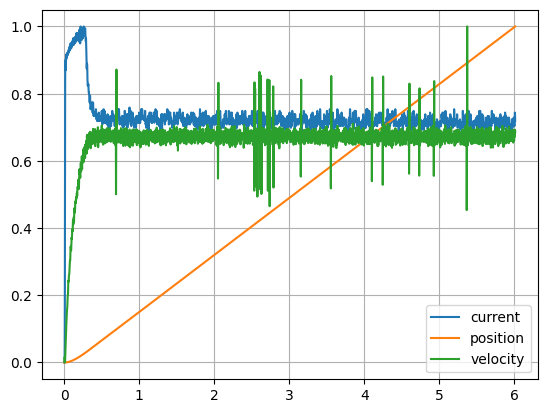

In [5]:
time, current, position = read_data(base.joinpath('data','data3.csv'))
# 速度の計算
velocity = calc_velocity(position, time)
accel = calc_acceleration(position, time)
# 描画
plot_graph(time, current, position, velocity, accel)

## フィルタリング処理

### ローパス

In [6]:
# ローパスをかける
def butter_lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

#### ローパス結果を描画

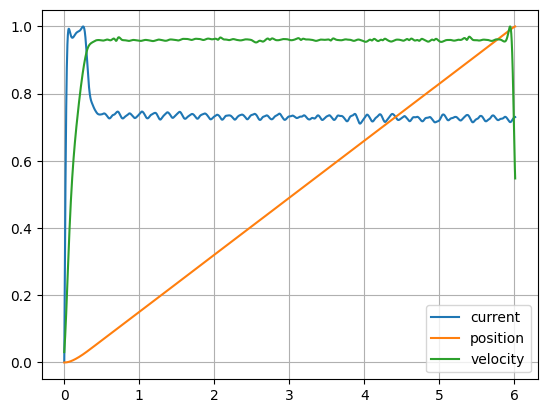

In [7]:
# Define the filter
cutoff = 10  # Desired cutoff frequency, Hz
fs = 500.0  # Sampling rate, Hz
order = 2  # Filter order


# Apply the filter
current_filtered = butter_lowpass_filter(current, cutoff, fs, order)
position_filtered = butter_lowpass_filter(position, cutoff, fs, order)

# 速度の計算
velocity_filtered = calc_velocity(position_filtered, time)
velocity_filtered = butter_lowpass_filter(velocity_filtered, cutoff, fs, order)

# 加速度の計算
accel_filtered = calc_acceleration(position_filtered, time)
accel_filtered = butter_lowpass_filter(accel_filtered, cutoff, fs, order)

plot_graph(time, current_filtered, position_filtered, velocity_filtered, accel_filtered)

### 外れ値除去

In [8]:
# 左右をカット
def cut_data(time, data, start, end):
    idx = (time >= start) & (time <= end)
    return time[idx], data[idx]

def cut_all_data(time, datas, start, end):
    idx = (time >= start) & (time <= end)
    return time[idx], (data[idx] for data in datas)

#### 除去後のデータを描画

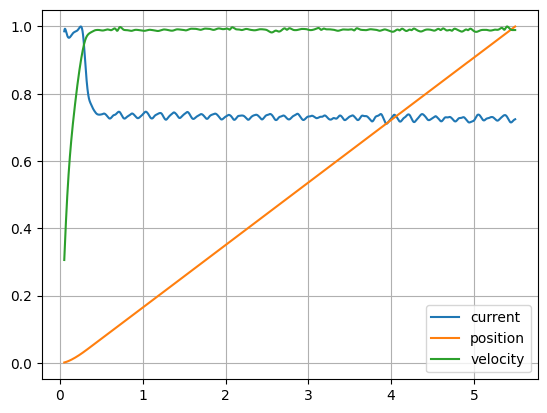

In [9]:
all_data = [current_filtered, position_filtered, velocity_filtered, accel_filtered]
time_cut, (cur_filt_cut,pos_filt_cut,vel_filt_cut,accel_filt_cut) = cut_all_data(time, all_data, 0.05, 5.5)
plot_graph(time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut)

## 前処理まとめ

In [10]:
# 今までの処理を関数化
def process_data(time, current, position, cutoff=10, start=0.05, end=5.5, dual_filtering=False):
    # positionのオフセット調整
    position = position - position[0]
    # 速度の計算
    velocity = calc_velocity(position, time)
    accel = calc_acceleration(position, time)
    
    # ローパスをかける
    # Define the filter
    fs = 500.0  # Sampling rate, Hz
    order = 2  # Filter order
    

    # Apply the filter
    current_filtered =  butter_lowpass_filter(current, cutoff, fs, order)
    position_filtered = butter_lowpass_filter(position, cutoff, fs, order)

    if dual_filtering: # 二重にフィルタリング
        # 速度の計算
        velocity_filtered = calc_velocity(position_filtered, time)
        velocity_filtered = butter_lowpass_filter(velocity_filtered, cutoff, fs, order)

        # 加速度の計算
        accel_filtered = calc_acceleration(position_filtered, time)
        accel_filtered = butter_lowpass_filter(accel_filtered, cutoff, fs, order)
    else:
        # 速度の計算
        velocity_filtered = butter_lowpass_filter(velocity, cutoff, fs, order)

        # 加速度の計算
        accel_filtered = butter_lowpass_filter(accel, cutoff, fs, order)
    

    all_data = [current_filtered, position_filtered, velocity_filtered, accel_filtered]
    time_cut, (cur_filt_cut,pos_filt_cut,vel_filt_cut,accel_filt_cut) = cut_all_data(time, all_data, start, end)

    return time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut

### 前処理全体の実行結果

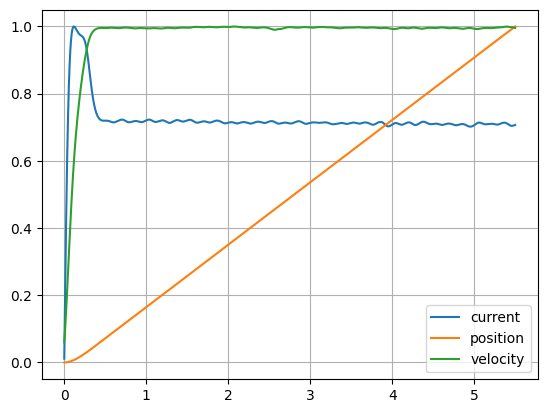

In [64]:
time, current, position = read_data(base.joinpath('data','data3.csv'))
time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut = process_data(time, current, position, cutoff=5, start=0.00, end=5.5, dual_filtering=False)
plot_graph(time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut)

# 最小二乗法でのパラメータ推定

## 係数行列・定ベクトル計算

In [12]:
def calc_mat_b(time:np.ndarray, cur:np.ndarray, pos:np.ndarray, vel:np.ndarray)->Tuple[np.ndarray,np.ndarray]:
    # J dw + D w = \int i dt
    diff_t = np.diff(time)
    int_cur = np.cumsum(cur[:-1]*diff_t)
    A = np.zeros((len(time)-1, 2))
    A[:,0] = vel[:-1]
    A[:,1] = pos[:-1]
    return A, int_cur

### 計算例

In [14]:
# 最小二乗法でパラメータ推定
A, b = calc_mat_b(time_cut, cur_filt_cut,pos_filt_cut, vel_filt_cut)
w = np.linalg.lstsq(A, b, rcond=None)[0]
J = w[0]
D = w[1]
print(f'J = {J}, D = {D}')

J = 0.013767731159487026, D = 0.06630487526886898


## 推定結果を用いて再構成

In [15]:
# 得られたパラメータを使って，4次ルンゲクッタ法でシミュレーション
def runge_kutta(f, t0, x0, v0, te, h):
    ts = np.arange(t0, te, h)
    xs = []
    vs = []
    x = x0
    v = v0
    for t in ts:
        xs.append(x)
        vs.append(v)
        k1 = f(t, v, x)
        l1 = v

        k2 = f(t + h/2, v + h/2*k1, x + h/2*l1)
        l2 = v + h/2*k1

        k3 = f(t + h/2, v + h/2*k2, x + h/2*l2)
        l3 = v + h/2*k2

        k4 = f(t + h, v + h*k3, x + h*l3)
        l4 = v + h*k3
        
        v = v + (k1 + 2*k2 + 2*k3 + k4)/6*h
        x = x + (l1 + 2*l2 + 2*l3 + l4)/6*h

    return (ts, np.array(xs), np.array(vs))

In [16]:
def compare_real_reconstruct(t_real,t_rec, pos_real,pos_rec, vel_real,vel_rec):
    plt.figure()
    # 描画の都合で正規化
    
    pos_norm = np.max(np.abs(pos_real))
    vel_norm = np.max(np.abs(vel_real))
    
    plt.plot(t_real, pos_real/pos_norm, label='real position')
    plt.plot(t_rec, pos_rec/pos_norm, label='reconstructed position')
    plt.plot(t_real, vel_real/vel_norm, label='real velocity')
    plt.plot(t_rec, vel_rec/vel_norm, label='reconstructed velocity')    

    plt.legend()
    plt.grid()

In [17]:
def func(t, v, x, J, D):
    # もっとも近いtをその時刻の電流とする
    idx = np.argmin(np.abs(time_cut - t))
    i = cur_filt_cut[idx]
    return (i - D*v) / J

### 実行例

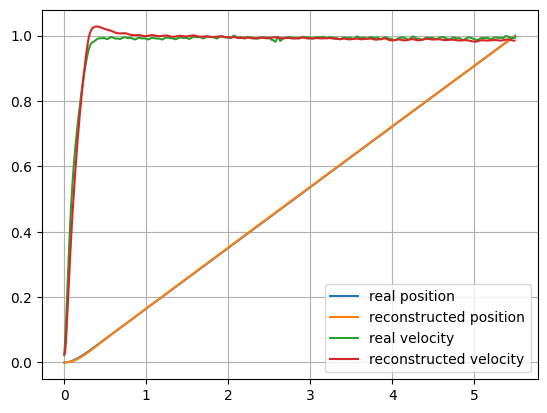

In [18]:
f = lambda t,v,x: func(t,v,x,J,D)
ts, xs,vs = runge_kutta(f, time_cut[0], pos_filt_cut[0], vel_filt_cut[0], time_cut[-1], 0.01)
compare_real_reconstruct(time_cut,ts, pos_filt_cut,xs, vel_filt_cut,vs)

In [27]:
# data0,..., data3 のデータを使って，パラメータ推定を行う
def estimate_params(data_name:List[str],cutoff=10, start=0.05, end=5.5, dual_filtering=True):
    As, bs = [],[]
    for name in data_name:
        time, current, position = read_data(base.joinpath('data',name))
        time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut = process_data(time, current, position, cutoff=cutoff, start=start, end=end, dual_filtering=dual_filtering)
        A, b = calc_mat_b(time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut)
        As.append(A)
        bs.append(b)
        
    A = np.vstack(As)
    b = np.hstack(bs)
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    J = w[0]
    D = w[1]    
    
    return J, D

In [88]:
# data_names = ['data0.csv','data1.csv','data2.csv','data3.csv']
data_names = ['data0.csv','data1.csv','data2.csv','data3.csv','data4.csv','data5.csv','data6.csv']
# data_names = ['data0.csv','data1.csv','data2.csv']
# data_names = ['data0.csv']


J, D = estimate_params(data_names, cutoff=20, start=0.0, end=5.5, dual_filtering=False)
f = lambda t,v,x: func(t,v,x,J,D)
print(f"J={J}, D={D}")


J=0.01038306503027827, D=0.06542060735147959


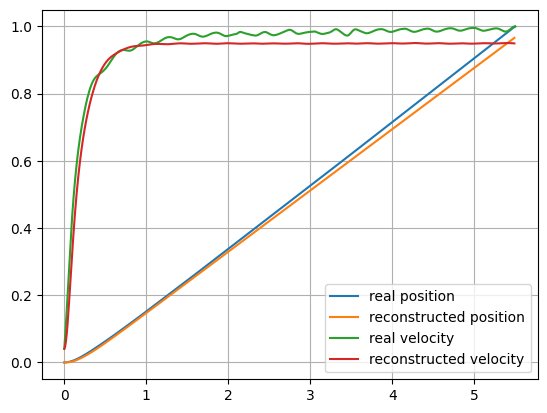

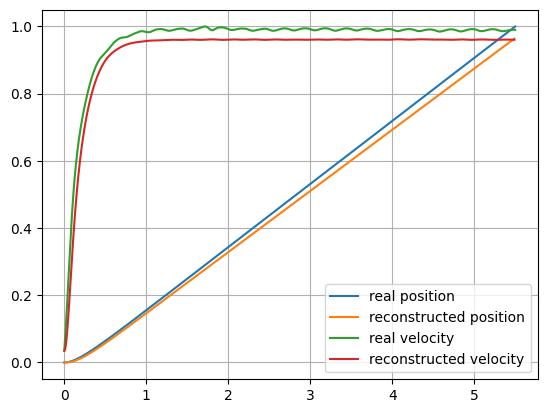

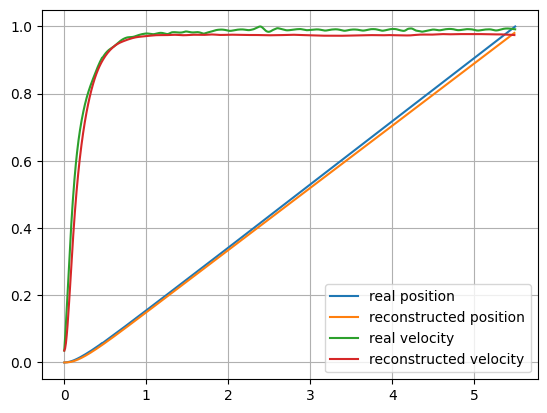

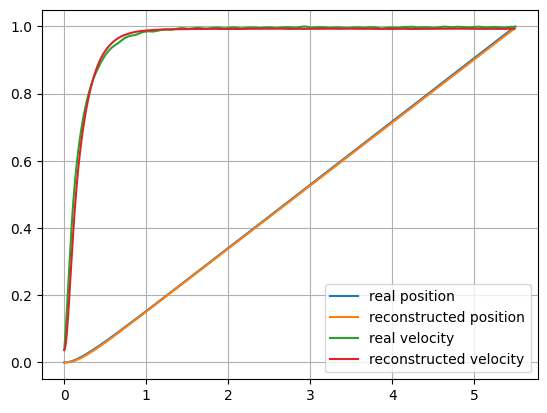

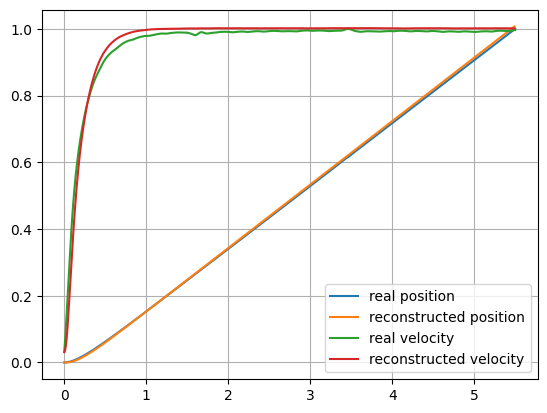

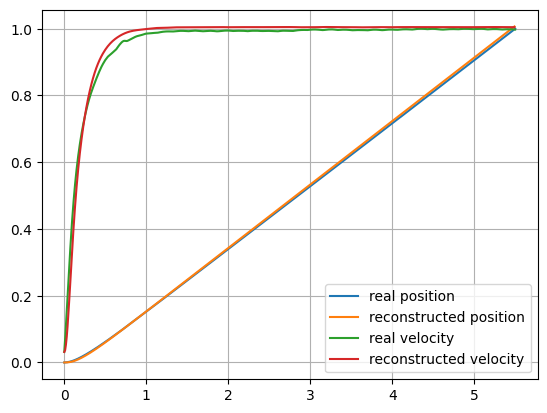

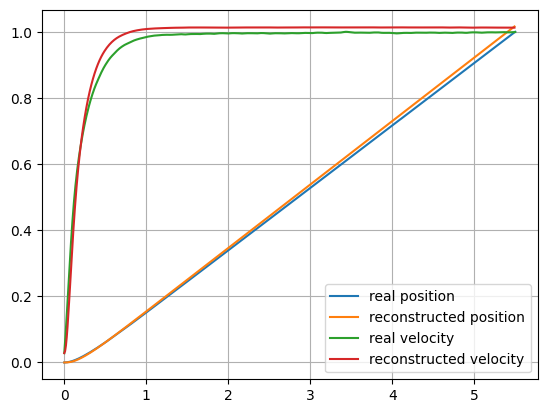

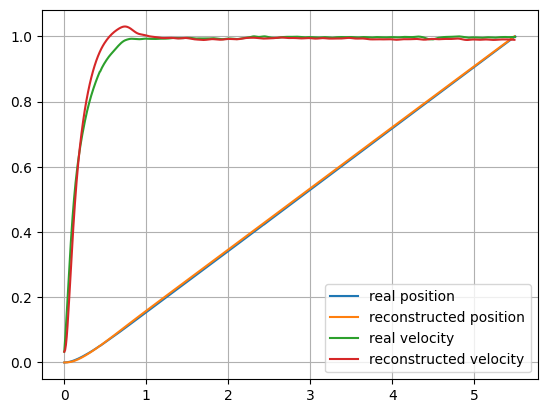

In [89]:
show_data_idx = 2
for show_data_idx in range(0,8):
    time, current, position = read_data(base.joinpath('data',f'data{show_data_idx}.csv'))
    time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut = process_data(time, current, position, cutoff=5, start=0.00, end=5.5, dual_filtering=False)
    t_start_idx = 0
    ts, xs,vs = runge_kutta(f, time_cut[t_start_idx], pos_filt_cut[t_start_idx], vel_filt_cut[t_start_idx], time_cut[-1], 0.01)
    compare_real_reconstruct(time_cut,ts, pos_filt_cut,xs, vel_filt_cut,vs)

# リファクタ後

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [2]:
def read_data(file):
    # Read the CSV file
    df = pd.read_csv(file)
    # Extract each column to arrays 
    time = df['time'].to_numpy()
    current = df['current'].to_numpy()
    position = df['position'].to_numpy()
    # positionのオフセット調整
    position = position - position[0]
    return time, current, position

# Read the CSV file
base = pathlib.Path().resolve().parent

In [3]:
def calc_velocity(position:np.ndarray, time:np.ndarray)->np.ndarray:
    velocity = np.zeros_like(position)
    velocity[0] = (position[1] - position[0]) / (time[1] - time[0]) # 始点は前方差分
    velocity[-1] = (position[-1] - position[-2]) / (time[-1] - time[-2]) # 終点は後方差分
    for i in range(1, len(time)-1):
        velocity[i] = (position[i+1] - position[i-1]) / (time[i+1] - time[i-1])
    return velocity

def calc_acceleration(position:np.ndarray, time:np.ndarray)->np.ndarray:
    acceleration = np.zeros_like(position)
    for i in range(1, len(time)-1):
        dt = (time[i+1] - time[i-1])/2
        acceleration[i] = (position[i+1] - 2*position[i] + position[i-1]) / (dt**2)
    
    # 始点・終点は計算ができないので，前後の値を代入
    acceleration[0] = acceleration[1]
    acceleration[-1] = acceleration[-2]
        
    return acceleration

In [4]:
def plot_graph(time, current, position, velocity, accel):
    plt.figure()
    # 描画の都合で正規化
    current = current / np.max(np.abs(current))
    position = position / np.max(np.abs(position))
    velocity = velocity / np.max(np.abs(velocity))
    accel = accel / np.max(np.abs(accel))
    
    plt.plot(time, current, label='current')
    plt.plot(time, position, label='position')
    plt.plot(time, velocity, label='velocity')
    #plt.plot(time, accel, label='acceleration')
    plt.legend()
    plt.grid()

In [5]:
# ローパス
def butter_lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# 左右をカット
def cut_data(time, data, start, end):
    idx = (time >= start) & (time <= end)
    return time[idx], data[idx]

def cut_all_data(time, datas, start, end):
    idx = (time >= start) & (time <= end)
    return time[idx], (data[idx] for data in datas)

In [6]:
# 今までの処理を関数化
def process_data(time, current, position, cutoff=10, start=0.05, end=5.5, dual_filtering=False):
    # positionのオフセット調整
    position = position - position[0]
    # 速度の計算
    velocity = calc_velocity(position, time)
    accel = calc_acceleration(position, time)
    
    # ローパスをかける
    # Define the filter
    fs = 500.0  # Sampling rate, Hz
    order = 2  # Filter order
    

    # Apply the filter
    current_filtered =  butter_lowpass_filter(current, cutoff, fs, order)
    position_filtered = butter_lowpass_filter(position, cutoff, fs, order)

    if dual_filtering: # 二重にフィルタリング
        # 速度の計算
        velocity_filtered = calc_velocity(position_filtered, time)
        velocity_filtered = butter_lowpass_filter(velocity_filtered, cutoff, fs, order)

        # 加速度の計算
        accel_filtered = calc_acceleration(position_filtered, time)
        accel_filtered = butter_lowpass_filter(accel_filtered, cutoff, fs, order)
    else:
        # 速度の計算
        velocity_filtered = butter_lowpass_filter(velocity, cutoff, fs, order)

        # 加速度の計算
        accel_filtered = butter_lowpass_filter(accel, cutoff, fs, order)
    

    all_data = [current_filtered, position_filtered, velocity_filtered, accel_filtered]
    time_cut, (cur_filt_cut,pos_filt_cut,vel_filt_cut,accel_filt_cut) = cut_all_data(time, all_data, start, end)

    return time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut

## データ描画
データを取得して，適度にフィルタリングをした結果を描画

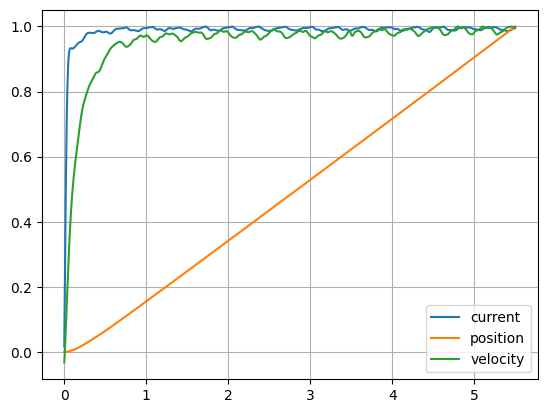

In [14]:
time, current, position = read_data(base.joinpath('data','data0.csv'))

time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut = process_data(time, current, position, cutoff=10, start=0.00, end=5.5, dual_filtering=False)
plot_graph(time_cut, cur_filt_cut, pos_filt_cut, vel_filt_cut, accel_filt_cut)